<a href="https://colab.research.google.com/github/soran-ghaderi/generative-models-colabs/blob/main/Training_EBM_Contrastive_Divergence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
#@title Licensed under the MIT License;
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://github.com/soran-ghaderi/generative-models-colabs/blob/main/LICENSE
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Tutorial: Training an Energy-Based Model with Contrastive Divergence using `torchebm`

This notebook will guide you through training a simple Energy-Based Model (EBM) on a synthetic dataset using the `torchebm` library. We'll cover:

1.  **What are EBMs?** A brief introduction.
2.  **Core Components:**
    *   Defining an **Energy Function** using a neural network.
    *   Setting up a **Sampler** (Langevin Dynamics) to generate negative samples.
    *   Using the **Contrastive Divergence (CD)** loss for training.
3.  **Data Preparation:** Using a synthetic Gaussian Mixture dataset.
4.  **Training Loop:** Putting all the pieces together to train the EBM.
5.  **Understanding the Output:** Interpreting the loss.

Let's get started!

## 1. Setup and Imports

First, we need to install `torchebm` if you haven't already.

In [2]:
# !pip install torchebm # Uncomment and run this cell if torchebm is not installed

Then, we import the necessary libraries.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np # For visualization

# torchebm components
from torchebm.core import (
    BaseEnergyFunction,
    CosineScheduler
)
from torchebm.samplers import LangevinDynamics
from torchebm.losses import ContrastiveDivergence # Your custom class is used here
from torchebm.datasets import GaussianMixtureDataset

# Helper for visualization
def plot_samples_and_energy(energy_fn, data_samples, generated_samples=None, title=""):
    plt.figure(figsize=(12, 5))

    # Plot data samples
    plt.subplot(1, 2, 1)
    plt.scatter(data_samples[:, 0], data_samples[:, 1], s=10, alpha=0.7, label="Real Data")
    if generated_samples is not None:
        plt.scatter(generated_samples[:, 0], generated_samples[:, 1], s=10, alpha=0.7, label="Generated Samples", c='red')
    plt.title("Data and Generated Samples")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.axis('equal')

    # Plot energy surface
    plt.subplot(1, 2, 2)
    x_range = np.linspace(min(data_samples[:,0].min(), -2), max(data_samples[:,0].max(), 2), 50)
    y_range = np.linspace(min(data_samples[:,1].min(), -2), max(data_samples[:,1].max(), 2), 50)
    X, Y = np.meshgrid(x_range, y_range)
    grid_points_np = np.stack([X.ravel(), Y.ravel()], axis=-1)
    grid_points_torch = torch.tensor(grid_points_np, dtype=torch.float32).to(next(energy_fn.parameters()).device)

    with torch.no_grad():
        energy_values = energy_fn(grid_points_torch).cpu().numpy().reshape(X.shape)

    contour = plt.contourf(X, Y, energy_values, levels=50, cmap='viridis')
    plt.colorbar(contour, label="Energy")
    plt.scatter(data_samples[:, 0], data_samples[:, 1], s=5, c='white', alpha=0.5, label="Real Data (on energy)")
    plt.title("Learned Energy Landscape")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.axis('equal')

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


---
## 2. What are Energy-Based Models (EBMs)?

Energy-Based Models define a scalar **energy function** $E_\theta(x)$ that associates an energy value to each input $x$. The parameters of this energy function are denoted by $\theta$. The probability of an input $x$ is then defined via the Boltzmann distribution:

$$p_\theta(x) = \frac{e^{-E_\theta(x)}}{Z(\theta)}$$

where $Z(\theta) = \int_x e^{-E_\theta(x)} dx$ is the partition function, which normalizes the distribution.

**The Goal of Training:** We want the EBM to assign **low energy** to data points similar to those in our training dataset (i.e., "real" data) and **high energy** to everything else.

Training EBMs can be challenging because the partition function $Z(\theta)$ is often intractable to compute directly. Contrastive Divergence is a common method to approximate the gradient of the log-likelihood without computing $Z(\theta)$.

---
## 3. Device Configuration

We'll use a GPU if available, otherwise a CPU.


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu



---
## 4. Defining the Core Components

### 4.1. The Energy Function

Our energy function will be a simple Multi-Layer Perceptron (MLP). It takes a 2D data point as input and outputs a single scalar value representing its energy.
`BaseEnergyFunction` is a simple base class that our custom energy model will inherit from.

In [5]:
class MLPEnergy(BaseEnergyFunction):
  def __init__(self, input_dim, hidden_dim):
    super().__init__()
    self.model = torch.nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.SELU(), # SELU can sometimes help with stable training
        nn.Linear(hidden_dim, hidden_dim),
        nn.SELU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.SELU(),
        nn.Linear(hidden_dim, 1), # Output a single scalar energy value
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # .squeeze(-1) removes the last dimension if it's 1, making the output (batch_size,)
    return self.model(x).squeeze(-1)

# Instantiate the energy function and move it to the selected device
INPUT_DIM = 2 # Our data is 2-dimensional
HIDDEN_DIM = 64 # hidden layer size
energy_fn = MLPEnergy(INPUT_DIM, HIDDEN_DIM).to(device)
print("Energy function defined and moved to device.")
print(energy_fn)

Energy function defined and moved to device.
MLPEnergy(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): SELU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): SELU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): SELU()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)


The energy function is a standard PyTorch `nn.Module`. The key is that its `forward` method should return a scalar energy for each input sample.

---

### 4.2. The Sampler: Langevin Dynamics

To train an EBM with Contrastive Divergence, we need a way to generate "negative" samples – samples that come from the model's current understanding of the data distribution. Langevin Dynamics is an MCMC (Markov Chain Monte Carlo) method that uses the gradient of the energy function to iteratively refine samples. For a state \( x_t \), the discretized update rule is:

$$
x_{t+1} = x_t - \eta \nabla E(x_t) + \sqrt{2\eta} \epsilon_t
$$

where $x_t$ is the sample at step $t$ and:
- $ E(x) $: Energy, where $ E(x) = -\log p(x) $ and $ p(x) $ is the target distribution.
- $ \eta $: Step size controlling the gradient descent.
- $ \epsilon_t \sim \mathcal{N}(0, I) $: Gaussian noise introducing stochasticity.

Over time, this process converges to samples from the Boltzmann distribution:

$$
p(x) \propto e^{-U(x)}
$$

We use `CosineScheduler` to anneal the `step_size` and `noise_scale` of the sampler during training, which can improve stability and sample quality.


In [6]:
EPOCHS = 30 # We'll use this for schedulers and training

# Schedulers for sampler parameters
SAMPLER_STEP_SIZE = CosineScheduler(start_value=3e-2, end_value=5e-3, n_steps=EPOCHS)
SAMPLER_NOISE_SCALE = CosineScheduler(start_value=3e-1, end_value=5e-2, n_steps=EPOCHS)
# SAMPLER_NOISE_SCALE = CosineScheduler(start_value=1e-1, end_value=1e-3, n_steps=EPOCHS)


# Define the sampler. Crucially, it uses our *trainable* energy_fn.
sampler = LangevinDynamics(
    energy_function=energy_fn,  # This tells the sampler whose gradients to use!
    step_size=SAMPLER_STEP_SIZE,
    noise_scale=SAMPLER_NOISE_SCALE,
    device=device
)
print("Langevin Dynamics sampler defined.")

Langevin Dynamics sampler defined.


**Important:** The `sampler` is initialized with our trainable `energy_fn`. This is vital because the sampler needs to use the gradients of the *current* energy function to generate samples that are representative of the model's current belief about low-energy regions.

#### Aside: How MCMC Samplers like Langevin Dynamics Work (Illustrative Example)

Let's briefly see how a sampler like Langevin Dynamics can generate samples from a *known* (analytical) energy function, like a simple Gaussian. This is *not* part of our EBM training loop for `MLPEnergy` but helps understand the sampler's role.


Shape of illustrative samples: torch.Size([500, 2])


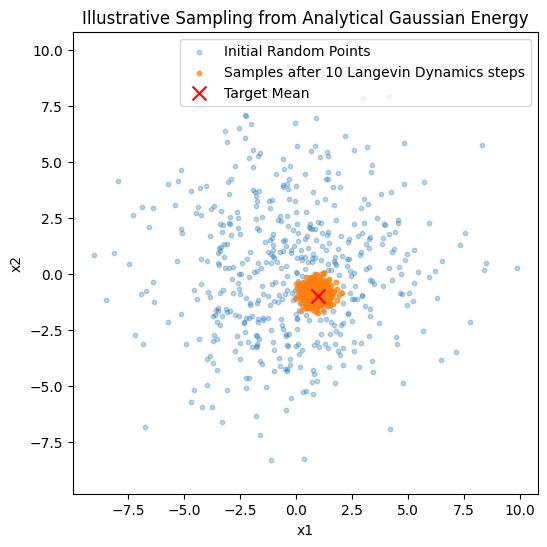

In [7]:
from torchebm.core import GaussianEnergy # An analytical energy function

# Define an analytical Gaussian energy function (not trainable here)
analytical_gaussian_energy = GaussianEnergy(mean=torch.tensor([1.0, -1.0], device=device),
                                           cov=torch.eye(2, device=device) * 0.5).to(device)

# Create a temporary sampler for this analytical energy
temp_sampler = LangevinDynamics(
    energy_function=analytical_gaussian_energy,
    step_size=0.1, # Fixed step size for this illustration
    noise_scale=0.1, # Fixed noise scale
    device=device
)
temp_n_steps = 10
# Generate samples starting from random noise
initial_points = torch.randn(500, INPUT_DIM, device=device) * 3 # Start further away
illustrative_samples = temp_sampler.sample(x=initial_points, n_steps=temp_n_steps) # Run for more steps

print(f"Shape of illustrative samples: {illustrative_samples.shape}")

# Visualize
plt.figure(figsize=(6,6))
plt.scatter(initial_points.cpu()[:,0], initial_points.cpu()[:,1], s=10, alpha=0.3, label="Initial Random Points")
plt.scatter(illustrative_samples.cpu()[:,0], illustrative_samples.cpu()[:,1], s=10, alpha=0.7, label=f"Samples after {temp_n_steps} Langevin Dynamics steps")
target_mean = analytical_gaussian_energy.mean.cpu().numpy()
plt.scatter(target_mean[0], target_mean[1], marker='x', s=100, c='red', label="Target Mean")
plt.title("Illustrative Sampling from Analytical Gaussian Energy")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.axis('equal')
plt.show()

As you can see, the sampler, guided by the gradients of the `analytical_gaussian_energy`, moves the initial random points towards the region of low energy (around the mean of the Gaussian). Our trainable EBM will use a similar process, but the `energy_fn` will be learned.

### 4.3. The Loss Function: Contrastive Divergence (CD-k)

Contrastive Divergence aims to approximate the gradient of the log-likelihood. The CD-k loss is typically formulated as:

$$\mathcal{L}_{CD} = \mathbb{E}_{p_{data}}[E_\theta(x_{data})] - \mathbb{E}_{p_k}[E_\theta(x_{model})]$$

where:
*   $x_{data}$ are samples from the true data distribution (positive samples).
*   $x_{model}$ are samples generated by running $k$ steps of MCMC (like Langevin Dynamics) starting from $x_{data}$ (negative samples).
*   We want to *minimize* this loss. This encourages the energy of real data samples ($E_\theta(x_{data})$) to be low, and the energy of model-generated (negative) samples ($E_\theta(x_{model})$) to be high.

The `ContrastiveDivergence` class (from your provided code, assumed to be in `torchebm.losses` or available in the environment) encapsulates this logic.


In [8]:
from torchebm.losses import ContrastiveDivergence

K_STEPS_CD = 20 # Number of MCMC steps for generating negative samples (k in CD-k)

# We are using non-persistent CD here.
# For persistent=False: MCMC chains start from real data samples for each batch.
# For persistent=True: MCMC chains are maintained and continued between updates,
#                      which can be more efficient but sometimes less stable.
cd_loss_fn = ContrastiveDivergence(
    energy_function=energy_fn, # The trainable energy function -> to sample fromm
    sampler=sampler,           # The sampler to generate negative samples
    k_steps=K_STEPS_CD,
    persistent=False,          # Standard CD-k (not Persistent CD)
    # energy_reg_weight=0.001    # Weight for L2 regularization on energy \
    # magnitudes -> tweak this, sometimes it prevents from learning the energy landscape efficiently
).to(device)

print("Contrastive Divergence loss function defined.")

Contrastive Divergence loss function defined.


The `energy_reg_weight` adds a small penalty $ \lambda (E(x_{data})^2 + E(x_{model})^2) $ to the loss, which helps prevent energy values from becoming too large and can stabilize training.

---
## 5. Data Preparation

We'll use a synthetic `GaussianMixtureDataset` which generates data points from a mixture of 2D Gaussian distributions.


Dataset created with 5000 samples.
DataLoader created with batch size 256.


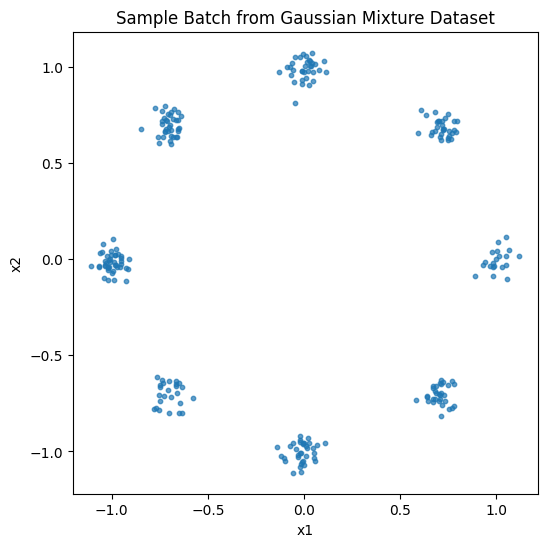

In [9]:
from torchebm.datasets import GaussianMixtureDataset, CheckerboardDataset

N_SAMPLES_DATASET = 5000
N_COMPONETS = 8
BATCH_SIZE = 256
DATASET = "checkerboard" # or 'gm'

dataset = GaussianMixtureDataset(
    n_samples=N_SAMPLES_DATASET,
    n_components=N_COMPONETS,
    seed=123 # For reproducibility
)
dataset_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
sample_batch_viz = next(iter(dataset_loader))

print(f"Dataset created with {len(dataset)} samples.")
print(f"DataLoader created with batch size {BATCH_SIZE}.")

# Let's visualize a batch of the data
plt.figure(figsize=(6,6))
plt.scatter(sample_batch_viz[:,0], sample_batch_viz[:,1], s=10, alpha=0.7)
plt.title("Sample Batch from Gaussian Mixture Dataset")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis('equal')
plt.show()


---
## 6. Optimizer

We'll use the Adam optimizer to update the parameters of our `energy_fn`.

In [10]:
LEARNING_RATE = 1e-3
optimizer = optim.Adam(energy_fn.parameters(), lr=LEARNING_RATE)
print("Adam optimizer defined.")

Adam optimizer defined.



---
## 7. The Training Loop

Now we put everything together. In each training step:
1.  Get a batch of real data.
2.  Pass this batch to `cd_loss_fn`.
    *   `cd_loss_fn` internally uses the `sampler` to run `k_steps` of MCMC, starting from the real data, to generate negative samples.
    *   It then computes the energies of real and negative samples using `energy_fn`.
    *   Finally, it calculates the CD loss: `E(real) - E(fake) + regularization`.
3.  Perform backpropagation on this loss.
4.  Update the `energy_fn` parameters using the optimizer.

Starting training for 30 epochs...
Device: cpu
Energy function parameters are on: cpu
CD loss function parameters (buffers like temperature) are on: cpu
Epoch 1/30, Avg Loss: -0.0054
Epoch 2/30, Avg Loss: -0.0133
Epoch 3/30, Avg Loss: -0.0242
Epoch 4/30, Avg Loss: -0.0325
Epoch 5/30, Avg Loss: -0.0396
Epoch 6/30, Avg Loss: -0.0372
Epoch 7/30, Avg Loss: -0.0311
Epoch 8/30, Avg Loss: -0.0233
Epoch 9/30, Avg Loss: -0.0182
Epoch 10/30, Avg Loss: -0.0128


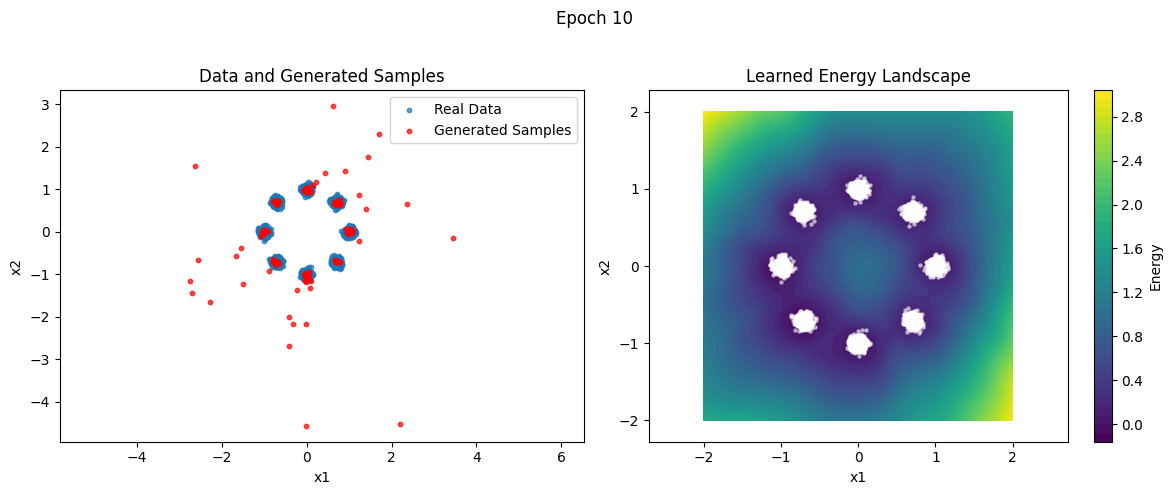

Epoch 11/30, Avg Loss: -0.0106
Epoch 12/30, Avg Loss: -0.0068
Epoch 13/30, Avg Loss: -0.0066
Epoch 14/30, Avg Loss: -0.0066
Epoch 15/30, Avg Loss: -0.0050
Epoch 16/30, Avg Loss: -0.0039
Epoch 17/30, Avg Loss: -0.0018
Epoch 18/30, Avg Loss: -0.0029
Epoch 19/30, Avg Loss: -0.0033
Epoch 20/30, Avg Loss: -0.0016


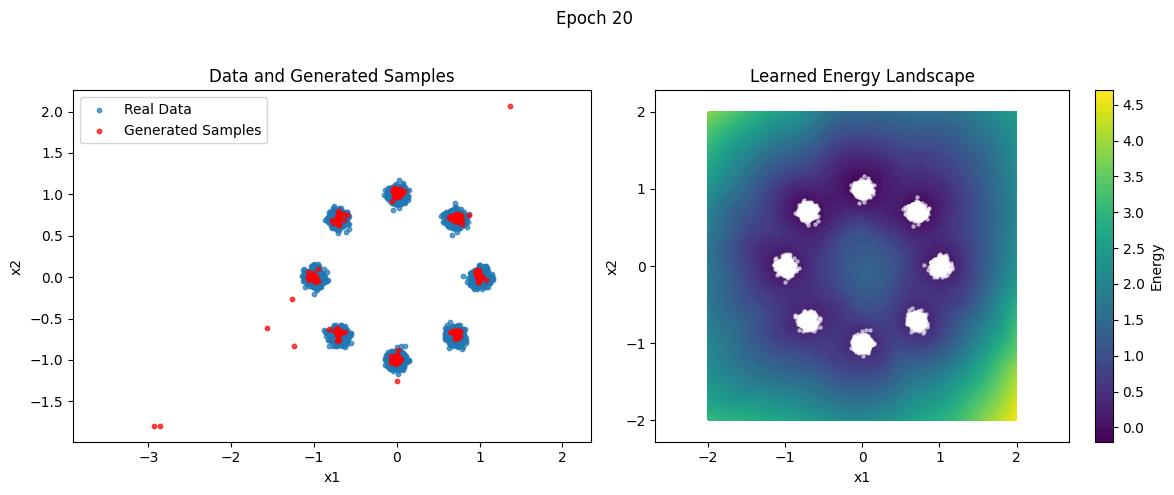

Epoch 21/30, Avg Loss: -0.0033
Epoch 22/30, Avg Loss: -0.0028
Epoch 23/30, Avg Loss: -0.0027
Epoch 24/30, Avg Loss: -0.0009
Epoch 25/30, Avg Loss: -0.0017
Epoch 26/30, Avg Loss: -0.0003
Epoch 27/30, Avg Loss: 0.0021
Epoch 28/30, Avg Loss: -0.0003
Epoch 29/30, Avg Loss: -0.0008
Epoch 30/30, Avg Loss: -0.0001


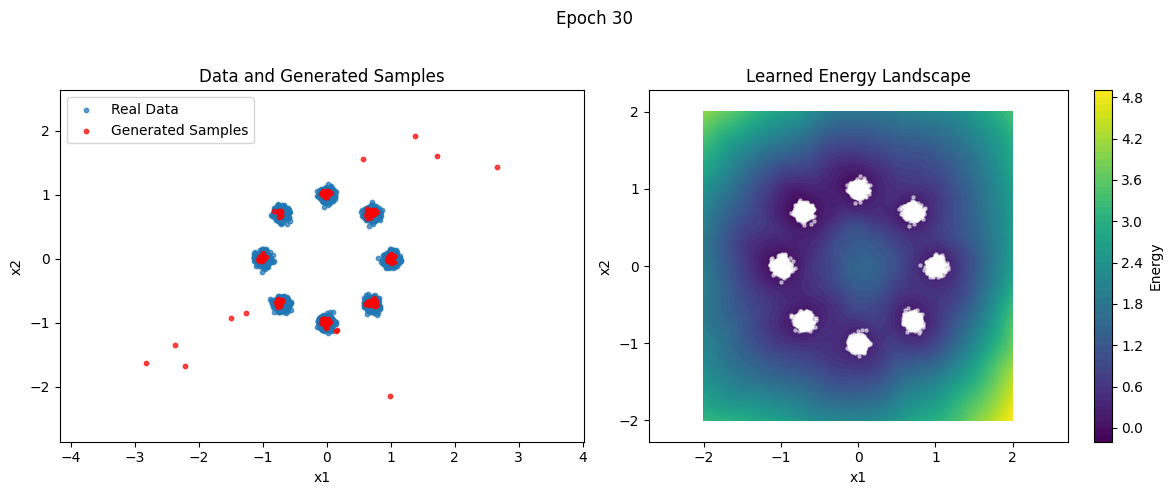

Training finished.


In [11]:
print(f"Starting training for {EPOCHS} epochs...")
print(f"Device: {device}")
print(f"Energy function parameters are on: {next(energy_fn.parameters()).device}")
print(f"CD loss function parameters (buffers like temperature) are on: {cd_loss_fn.temperature.device if hasattr(cd_loss_fn, 'temperature') else 'N/A (no temp buffer)'}")


all_batch_losses = []

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    energy_fn.train() # Set model to training mode

    for i, real_batch in enumerate(dataset_loader):
        # Ensure data is on the correct device
        if not real_batch.device == energy_fn.device:
          real_batch = real_batch.to(device)

        optimizer.zero_grad()

        # Compute CD loss and get negative samples
        # The cd_loss_fn handles:
        # 1. Generating negative samples using self.sampler (which uses self.energy_function)
        # 2. Calculating E(real_batch) and E(negative_samples) using self.energy_function
        # 3. Returning the loss: E(real) - E(negative) + regularization
        loss, neg_samples = cd_loss_fn(real_batch)

        # Backpropagate and update
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        # all_batch_losses.append(loss.item())

    avg_epoch_loss = epoch_loss / len(dataset_loader)
    all_batch_losses.append(avg_epoch_loss)
    print(f"Epoch {epoch + 1}/{EPOCHS}, Avg Loss: {avg_epoch_loss:.4f}")

    # Optional: Visualize every few epochs
    if (epoch + 1) % 10 == 0 or epoch == EPOCHS -1 :
        energy_fn.eval() # Set model to evaluation mode for consistent sampling
        # Generate some samples from the learned model for visualization
        # Start MCMC from random noise to see what the model has learned
        vis_initial_points = torch.randn(200, INPUT_DIM, device=device) * 2 # Spread out initial points
        with torch.no_grad(): # No gradients needed for visualization sampling
            # Use a fresh sampler instance or ensure its state is reset if it has internal state from training
            # For Langevin, it's generally stateless for the sample() call itself regarding chain history
            # but step_size/noise_scale might have been annealed. For viz, we  use current annealed values.
            N_STEPS = 200
            _SAMPLER_STEP_SIZE = CosineScheduler(start_value=3e-2, end_value=5e-3, n_steps=N_STEPS)
            _SAMPLER_NOISE_SCALE = CosineScheduler(start_value=1e-1, end_value=5e-2, n_steps=N_STEPS)

            vis_sampler = LangevinDynamics(
                energy_function=energy_fn, # Use the *current* trained energy_fn
                # step_size=_SAMPLER_STEP_SIZE,
                # noise_scale=_SAMPLER_NOISE_SCALE,
                step_size=sampler.step_size.get_value() if hasattr(sampler.step_size, 'get_value') else sampler.step_size,
                noise_scale=sampler.noise_scale.get_value() if hasattr(sampler.noise_scale, 'get_value') else sampler.noise_scale,
                device=device
            )
            generated_vis_samples = vis_sampler.sample(x=vis_initial_points, n_steps=N_STEPS).cpu().numpy() # More steps for viz

        plot_samples_and_energy(
            energy_fn,
            dataset.get_data().cpu().numpy(), # Plot all training data for context
            generated_vis_samples,
            title=f"Epoch {epoch + 1}"
        )

print("Training finished.")


---
## 8. Analyzing the Output and Next Steps

### Loss Curve
Let's plot the batch losses over training time.

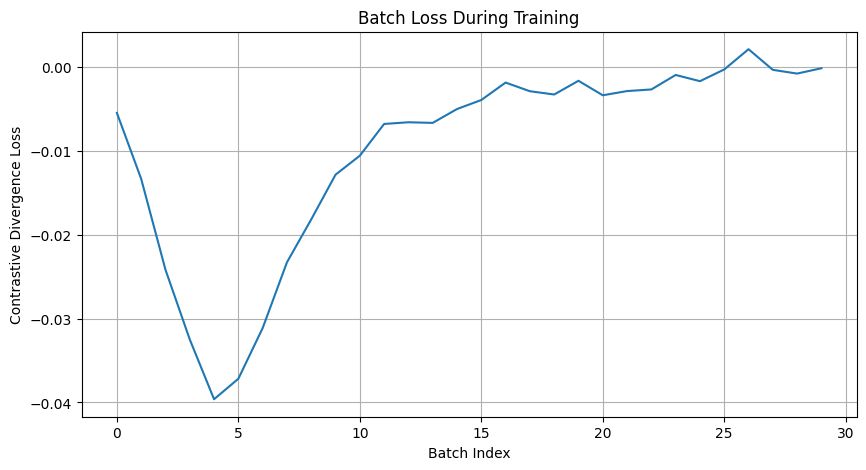

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(all_batch_losses)
plt.title("Batch Loss During Training")
plt.xlabel("Batch Index")
plt.ylabel("Contrastive Divergence Loss")
plt.grid(True)
plt.show()



**Interpreting the Loss:**
*   The CD loss is `E(real) - E(fake) + regularization`.
*   We expect this loss to **decrease** over training.
*   A positive loss value is typical: it means the energy of real samples is lower than the energy of generated (fake/negative) samples, which is what we want.
*   If the loss becomes consistently very negative, it might indicate issues like the sampler not exploring well (poor negative samples) or model collapse.
*   The magnitude of the loss can vary greatly depending on the data, model, and hyperparameters. The trend is more important.

**Visualizations:**
The plots generated during training should show:
1.  **Data and Generated Samples:** The generated samples (red) should start to resemble the distribution of the real data (blue) as training progresses.
2.  **Learned Energy Surface:** The energy surface should show low-energy regions (darker colors) aligning with the modes of the true data distribution.

### Further Steps and Considerations:

*   **Hyperparameter Tuning:**
    *   `K_STEPS_CD`: More steps give better negative samples but are slower.
    *   `SAMPLER_STEP_SIZE`, `SAMPLER_NOISE_SCALE`: Critical for MCMC sampler performance. Schedulers help.
    *   `LEARNING_RATE`: Standard optimizer hyperparameter.
    *   `energy_reg_weight`: Balances fitting the data vs. keeping energies small.
    *   `persistent` in `ContrastiveDivergence`: Using `persistent=True` (Persistent Contrastive Divergence - PCD) can sometimes lead to better samples, especially for complex distributions, but might require more careful tuning (e.g., `buffer_size`, `new_sample_ratio`).
*   **Model Architecture:** The complexity of `MLPEnergy` (number of layers, hidden units) can be adjusted.
*   **Evaluation Metrics:** Beyond visual inspection, you can use metrics like Inception Score or Frechet Inception Distance (FID) for image data.
*   **More Complex Data:** Try this framework on image datasets like MNIST or CIFAR-10 (you'll need to adjust the `INPUT_DIM` and likely the model architecture).

This tutorial provides a basic framework for training EBMs. Experiment with different settings and datasets to get a better feel for how they work!